In [1]:
import torch.distributions as distrib
import torch.distributions.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import torch as tr

import matplotlib.pyplot as plt

import numpy as np

# Variational inference
In variational inference we specify a family $\mathcal{D}$ of densities over the lantent variables that we want to infer given by $q(z) \in \mathcal{D}$. Our goal is the find the best candidate that is closest to the actual posterior.
$$ q^*(z) = arg\min_{q(z)\in \mathcal{D}} D_{KL}(q(z)||p(z|x))$$
Note that this objective is intractable, just notice that we can rewrite it as
$$D_{KL}(q(z)||p(z|x)) =  \int q(z) \log \frac{q(z)}{p(z|x)} dz = \mathbb{E}_q[\log q(z)]-\mathbb{E}_q[\log p(z|x)] = \mathbb{E}_q[\log q(z)]-\mathbb{E}_q[\log p(x,z)]   + \log p(x) $$
Hence it would require to evaluate the log evidence $\log p(x)$ which is typically not possible. Thus we typically optimize an alternative objective that is equivalent up to an constant (the log evidence!), which we call ELBO:
$$ \mathcal{L}(q) = \mathbb{E}_q[\log p(z,x)]-\mathbb{E}_q[\log q(z)]$$
Maximizing the ELBO is equivalent to minimizing the KL divergence. Fruther as the KL divergence is greater then zero, the ELBO is a lower bound to the evidence.

Examining the ELBO gives intuitions about the optimal variation density, hence lets consider how we can rewrite the ELBO:
$$ \mathcal{L}(q) = \mathbb{E}[\log p(z)] + \mathbb{E}[\log p(x|z)] - \mathbb{E}[\log q(z)] = \mathbb{E}[\log p(x|z)] - D_{KL}(q(z)||p(z))$$

Hence we maximize the expected log likelihood, hence encourages to place mass on latent variable configurations that explain the data well, but also minimizes the KL divergence between the variational distribution and the prior.

## 1) Variational inference for logistic regression

With logsitc regression we want to linearly classify labeled data $(x,y)$ where $x \in \mathbb{R}$ and $y \in \{0,1\}$. We use following discrimative model
$$ p(y|w) = Bern(y; \sigma(w^Tx)) \quad w \sim \mathcal{N}(w;0,I)$$
where $\sigma$ is the sigmoid function. This simple model is intractable to solve analytically as $\sigma$ is a nonlinear transformation. Hence lets try to derive a simple variational inference algorithm.

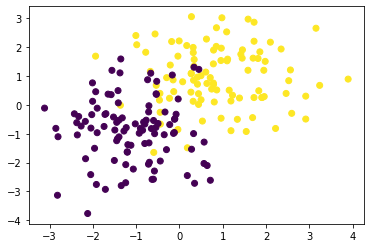

In [6]:
mean1 = 1
mean2 = -1
N = 200
X = tr.vstack((mean1 + tr.randn((100,2)), mean2 + tr.randn((100,2))))
y = tr.hstack((tr.ones(100), tr.zeros(100)))

plt.scatter(X[:,0], X[:,1], c=y)

Above we see the clusters that we want to classify. We will assume that the posterior is a multivariate Gaussian distribution with variable mean and covariance $q(w) = \mathcal{N}(w; \mu, \Sigma)$.
$$ 
\begin{align*}
\mathcal{L}(q) &= \mathbb{E}_q[\log q(w)] - \mathbb{E}_q[\log p(y|w)] - \mathbb{E}_q[\log p(w)]\\
&= \mathbb{E}_q[\log \mathcal{N}(w;mu, \Sigma)] - \mathbb{E}_q[\log \mathcal{N}(w;0, I)] - \sum_{i=1}^N\mathbb{E}_q[ y_i \log\sigma(w^Tx_i) + (1-y_i)\log(1-\sigma(w^Tx_i))]\\
&= \mathbb{E}_q[\log \mathcal{N}(w;mu, \Sigma)] - \mathbb{E}_q[\log \mathcal{N}(w;0, I)] - \sum_{i=1}^N\mathbb{E}_q[ y_i \log\sigma(w^Tx_i) + (1-y_i)\log(1-\sigma(w^Tx_i))]
\end{align*}
$$ 
We will approxiamte the expectations using Monte Carlo approximations. The gradients for $\mu, \Sigma$ can be compute as for Gaussian we can use the reparameterization trick.

In [7]:
p_w = tr.distributions.MultivariateNormal(tr.zeros(2),tr.eye(2) )

mu = tr.randn(2, requires_grad=True)
std = tr.eye(2, requires_grad=True)

def elbo(mu, std, mcmc=1):
    cov = std@std.T
    q_w = tr.distributions.MultivariateNormal(mu,cov)

    v = tr.randn((2,mcmc))
    s = mu.repeat(mcmc,1).T.view(2,mcmc) + std@v

    elbo_prior = p_w.log_prob(s.T)
    elbo_q = q_w.log_prob(s.T)
    elbo_ll = tr.sum(y.repeat(mcmc).view(mcmc,len(y))*tr.log(tr.sigmoid((X@s).T)) + ((1-y).repeat(mcmc).view(mcmc,len(y))*tr.log(1-tr.sigmoid((X@s).T))), axis=1)

    return (elbo_q - elbo_prior - elbo_ll).mean()

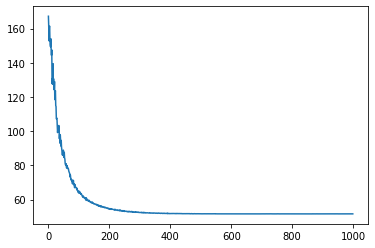

In [8]:
lr = 1e-2
elbos = []
mu_final = tr.zeros(2) # Mean to train
std_final = tr.eye(2)  # Standard deviation to train
optimizer = tr.optim.Adam([mu, std], lr=lr)
for i in range(1000):
    optimizer.zero_grad()
    loss = elbo(mu,std,mcmc=256)
    elbos.append(loss.detach())
    loss.backward()
    optimizer.step()
    # Save best model
    with tr.no_grad():
        if loss <= tr.min(tr.tensor(elbos)):
            mu_final = mu.clone().detach()
            std_final = std.clone().detach()

plt.plot(elbos)

This worked rather nice. The resulting distribution over decision planes is shown below.

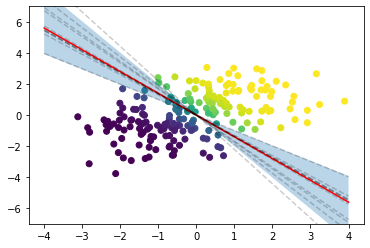

In [9]:
w = mu_final.detach()
covar = (std_final@std_final.T).detach()
samples = np.random.multivariate_normal(w, covar, size=20000)

a = -w[0] / w[1]
ass = -samples[:,0]/samples[:,1]
xx = tr.linspace(-4,4)
yy = a * xx
plt.scatter(X[:,0], X[:,1], c=tr.sigmoid(X@w))
q = np.percentile(ass,[5,95])
plt.fill_between(xx,q[0]*xx, q[1]*xx, alpha=0.3)
plt.plot(xx,yy, "red")
plt.ylim(-7,7)
for s in samples[:10]:
    a = -s[0] / s[1]
    yy = a * xx
    plt.plot(xx,yy, "--", color="black", alpha = 0.2)

## 2) Variational inference for normalizing flows

In the previous example we restricted the posterior to be Gaussian. This made inference rather simple, however, the true posterior is clearly not Gaussian and hence we cannot obtain the correct posterior.

Instead we may use normalizing flows to define the variational family over we optimize. We observed previously that normalizing flows are very flexible and hence it becomes likely the actual posterior can be represented. We wish to infere latent variables $z$, we use a flow-based model to approximate the posterior 
$$ p(z|x) \approx q(z|\phi) = q_0(u) |\det J_T(u;\phi)|^{-1}$$
where $q_0$ is the base distribution and $T(\cdot; \phi)$ are the transformations paramterized by $\phi$. The ELBO is then given by
$$ \mathcal{L}(q) = \mathbb{E}_q[\log q(z|\phi) - \log p(x,z)] = \mathbb{E}_{q_0}[\log q_0(z_0)] -  \mathbb{E}_{q_0}[ \log \det J_T(z_0; \phi)] - \mathbb{E}_{q_0}[\log p(x, T(z_0,\phi))]$$
Lets implement this flow based inference procedure

In [10]:
class Flow(transform.Transform, nn.Module):
    """ Abstract Flow class: Importas module to be able to train paramters properly """
    def __init__(self, *args, **kwargs):
        super().__init__(*args,**kwargs)
        super(nn.Module, self).__init__()
    
    def init_parameters(self):
        """ Initialization of paramters """
        for param in self.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    # Hacky hash bypass (for optimization this is needed)
    def __hash__(self):
        return super(nn.Module,self).__hash__()

class PlanarFlow(Flow):
    def __init__(self, dim, h=tr.tanh, hp=(lambda x: 1 - tr.tanh(x) ** 2), bound = 1, *args, **kwargs):
        kwargs["cache_size"] = 1
        super(PlanarFlow, self).__init__(*args,**kwargs)
        # Paramters
        self.u = nn.Parameter(tr.Tensor(dim))
        self.lin = nn.Linear(dim,1)
        self.init_parameters()
        # Nonlinearity
        self.h = h
        self.hp = hp
        self.bound=1

    def _invertible_u(self):
        # Ensures invertibility of mapping
        u = self.u
        w = self.lin.weight.squeeze(0)
        alpha = tr.dot(u,w)
        a_prime = -self.bound + F.softplus(alpha)
        return u + (a_prime - alpha) * w.div(w.norm())

    def _call(self, x):
        y = x + self._invertible_u() * self.h(self.lin(x))
        return y

    def _inverse(self,y):
        x_old, y_old = self._cached_x_y
        if (y_old == y).all():
            return x_old

    def log_abs_det_jacobian(self, x,y):
        f_y = self.lin(y)
        psi = self.hp(f_y) * self.lin.weight
        det_grad = 1 + tr.matmul(psi, self._invertible_u()).unsqueeze(-1)
        return tr.log(det_grad.abs() + 1e-9) # Nugget to stay positive

In [11]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, transforms, density):
        super().__init__()
        biject = []
        for f in transforms:
            biject.append(f)
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z,z))
            z = self.bijectors[b](z)
        return z, self.log_det

Lets also implement a flow based model for logistic regression.
$$ \mathcal{L}(q) = \mathbb{E}_{q_0}[\log q_0(z_0)] -  \mathbb{E}_{q_0}[ \log \det J_T(z_0; \phi)] - \mathbb{E}_{q_0}[\log p(x, T(z_0,\phi))]$$

In [41]:
flow = NormalizingFlow(2, [PlanarFlow(2) for _ in range(16)], distrib.MultivariateNormal(tr.zeros(2), tr.eye(2)))

In [42]:
def elbo(flow, mcmc = 100):
    z_0 = flow.base_density.sample_n(mcmc)
    z_k, log_dets = flow(z_0)

    elbo_q0 = flow.base_density.log_prob(z_0)
    elbo_dets = sum(log_dets)
    elbo_prior = p_w.log_prob(z_k)
    elbo_ll = tr.sum(y.repeat(mcmc).view(mcmc,len(y))*tr.log(tr.sigmoid((X@z_k.T).T)) + ((1-y).repeat(mcmc).view(mcmc,len(y))*tr.log(1-tr.sigmoid((X@z_k.T).T))), axis=1)

    return (elbo_q0 - elbo_dets - elbo_prior - elbo_ll).mean()

In [43]:
optimizer = tr.optim.Adam(flow.parameters(), lr=10e-3)
scheduler = tr.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
ref_distrib = distrib.MultivariateNormal(tr.zeros(2), tr.eye(2))
for it in range(501):
    optimizer.zero_grad()
    loss_v = elbo(flow, mcmc=1024)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 50 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))

Loss (it. 0) : 175.582367
Loss (it. 50) : 52.758797
Loss (it. 100) : 51.870480
Loss (it. 150) : 51.791836
Loss (it. 200) : 51.733833
Loss (it. 250) : 51.729080
Loss (it. 300) : 51.707787
Loss (it. 350) : 51.725521
Loss (it. 400) : 51.719395
Loss (it. 450) : 51.701164
Loss (it. 500) : 51.710892


In [44]:
samples = flow.final_density.sample_n(100000)

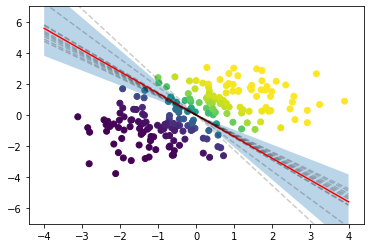

In [45]:
w = samples.mean(axis=0)

a = -w[0] / w[1]
ass = -samples[:,0]/samples[:,1]
xx = tr.linspace(-4,4)
yy = a * xx
plt.scatter(X[:,0], X[:,1], c=tr.sigmoid(X@w))
q = np.percentile(ass,[5,95])
plt.fill_between(xx,q[0]*xx, q[1]*xx, alpha=0.3)
plt.plot(xx,yy, "red")
plt.ylim(-7,7)
for s in samples[:10]:
    a = -s[0] / s[1]
    yy = a * xx
    plt.plot(xx,yy, "--", color="black", alpha = 0.2)

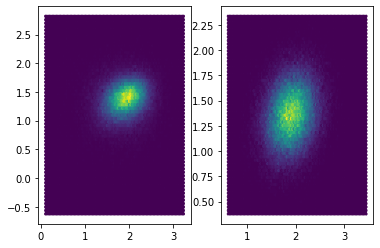

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hexbin(samples[:,0], samples[:,1])

w = mu_final.detach()
covar = (std_final@std_final.T).detach()
samples_2 = np.random.multivariate_normal(w, covar, size=100000)
ax2.hexbin(samples_2[:,0], samples_2[:,1])

We observe that the posterirors are rather similar. However the second is restricted to be Gaussian, hence must be symmetric. The flow based model on the other hand is more flexible and adjust to the typically non-symmetric posterior of a logistic model.

## Papers

* Blei, D. M., Kucukelbir, A., & McAuliffe, J. D. (2017). Variational inference: A review for statisticians. Journal of the American statistical Association, 112(518), 859-877.
* Rezende, D., & Mohamed, S. (2015, June). Variational inference with normalizing flows. In International Conference on Machine Learning (pp. 1530-1538). PMLR.
* Papamakarios, G., Nalisnick, E., Rezende, D. J., Mohamed, S., & Lakshminarayanan, B. (2019). Normalizing flows for probabilistic modeling and inference. arXiv preprint arXiv:1912.02762.
